# Assignment Chapter 3 - COMPUTER VISION [Case #2]
Startup Campus, Indonesia - `Artificial Intelligence (AI)` (Batch 7)
* Dataset: MNIST Handwritten Digits (10 classes)
* Libraries: PyTorch, Torchvision, Scikit-learn
* Objective: Transfer Learning using CNN-based Pre-trained Models

`PERSYARATAN` Semua modul (termasuk versi yang sesuai) sudah di-install dengan benar.
<br>`CARA PENGERJAAN` Lengkapi baris kode yang ditandai dengan **#TODO**.
<br>`TARGET PORTFOLIO` Peserta mampu:
* mengimplementasikan teknik *transfer learning* dengan berbagai model *pre-trained* dari PyTorch, dan
* menilai efek pembekuan (*freezing*) beberapa bagian dari layer *neural network*.

<br>`PERINGATAN` **DILARANG MENGUBAH** kode yang ada di dalam *user-defined function (UDFs)*.

### Deskripsi
Sebuah fasilitas robot (*robotics facility*) baru yang berlokasi di Kalimantan Timur, dekat Titik Nol Ibu Kota Negara (IKN) Indonesia, meminta Anda untuk membuat model *Computer Vision* untuk produk robot baru mereka. Perusahaan meminta Anda untuk mengajari robot cara membaca rangkaian angka. Anda tiba-tiba menyadari bahwa tahap pertama adalah membiarkan robot mengidentifikasi setiap digit dengan benar (0-9). Namun, karena tanggal pengumuman prototipe dipercepat, *deadline* Anda sangat ketat: Anda hanya memiliki waktu kurang dari 1 minggu untuk menyelesaikan pekerjaan. Sebagai pengembang AI profesional, Anda tetap tenang dan tahu bahwa Anda dapat memanfaatkan metode **Transfer Learning** untuk menyelesaikan masalah ini secara efisien.

Database **Modified National Institute of Standards and Technology (MNIST)** berisi 10 digit tulisan tangan. Semuanya berada dalam skala grayscale (1 channel). Torchvision, sub-library dari PyTorch, memiliki lusinan model terlatih yang dapat Anda pilih dengan mudah. Semua model ini awalnya dilatih pada kumpulan data ImageNet [(ref1)](https://www.image-net.org/download.php), yang berisi jutaan gambar RGB (3 channel) dan 1.000 kelas. Untuk mempermudah, pilihlah **Resnet18** [(ref2)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), **DenseNet121** [(ref3)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf), and **Vision Transformer (ViT)** [(ref4)](https://arxiv.org/pdf/2010.11929.pdf) sebagai model dasar (namun canggih) untuk menguji performa klasifikasi gambar. Sekarang, tugas lengkap Anda adalah sebagai berikut.

1. Pilih DenseNet sebagai model pertama untuk bereksperimen, lalu **ubah jumlah neuron di lapisan pertama dan terakhir** (karena ImageNet memiliki 1.000 kelas, sedangkan MNIST hanya memiliki 10 kelas; keduanya juga memiliki ukuran gambar dan *channel* yang berbeda).
2. Tentukan **hyperparameter** dan latih modelnya (semua layer dilatih dari awal).
3. Plot performa model, baik untuk hasil **pelatihan** maupun **validasi**.
4. Sekarang, coba **bekukan (freeze, tidak dilatih) beberapa bagian dari layer**: (1) "denseblock1", (2) "denseblock1" dan "denseblock2". Ini akan menjadi dua model terpisah.
5. **Latih kembali** (*retrain*) setiap model, visualisasikan performanya, dan periksa perbedaannya.
6. BONUS: Bisakah Anda **mereplikasi** semua langkah di atas dengan model yang berbeda, misalnya **ResNet** dan **ViT**?

### Import libraries

In [ ]:
import torch, torchvision, time
from numpy.random import seed
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-5061f0ddd5d4>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
torch.__version__ == "2.0.1+cu117"

False

In [ ]:
torchvision.__version__ == "0.15.2+cu117"

False

In [ ]:
# define seeding
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

### User-defined Functions (UDFs)

- To print total model parameters

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

- To get the pair of train and validation dataloaders

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
])

train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform, download=True).train_data.float()

def get_dataloaders(train_batch_size : int, val_batch_size : int, max_rows : int = 1000, *args, **kwargs) -> tuple:
    data_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform)
    train_idx = torch.randperm(len(train_dataset))[:int(max_rows*.75)]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, \
                                               sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=data_transform)
    val_idx = torch.randperm(len(val_dataset))[:int(max_rows*.25)]
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, \
                                             sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    return train_loader, val_loader

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.36MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



* To fit (training) the model

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

* To visualize the model performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Define the model class

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection : str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 1

        def create_conv2d(this_layer, *args, **kwargs) -> torch.nn.modules.conv.Conv2d:
            return torch.nn.Conv2d(
                in_channels=self.in_channels, out_channels=this_layer.out_channels,
                kernel_size=this_layer.kernel_size, stride=this_layer.stride,
                padding=this_layer.padding, bias=this_layer.bias
            )

        if not self.model_selection.lower() in ["resnet", "densenet", "vit"]:
            raise ValueError("Please select the model: 'resnet', 'densenet', or 'vit'.")

        if self.model_selection == "resnet":
            self.model = torchvision.models.resnet18(pretrained=True)
            self.model.conv1 = create_conv2d(self.model.conv1) # change the input layer to take Grayscale image, instead of RGB
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10) # change the output layer to output 10 classes

        elif self.model_selection == "densenet":
            self.model = torchvision.models.densenet121(pretrained=True)
            self.model.features.conv0 = create_conv2d(self.model.features.conv0)  # TODO: Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 10)  # TODO: Ubah output layer DenseNet dengan 10 kelas

        elif self.model_selection == "vit":
            self.model = torchvision.models.vit_b_16(pretrained=True)
            self.model.conv_proj = create_conv2d(self.model.conv_proj)  # TODO: TODO: Ubah susunan input layer ViT dengan memanggil create_conv2d()
            self.model.classifier = torch.nn.Linear(self.model.heads.head.in_features, 10) # TODO: Ubah output layer ViT dengan 10 kelas

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torchvision.models:
        x = self.model(data)
        return self.softmax(x)

### Set device to CUDA
**PERHATIAN**: Di Google Colab, klik Runtime > Change Runtime Type, lalu pilih **T4 GPU**.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define hyperparameters

In [ ]:
EPOCH = 5
BATCH_SIZE = 25 # TODO: Tentukan nilai batch size
LEARNING_RATE = 0.1 # TODO: Tentukan nilai learning rate

### Define the model

In [ ]:
# TODO: Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
model = VisionModel("densenet").to(device)
check_params(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]


{'total_trainable_params': 6957834, 'total_nontrainable_params': 0}

In [ ]:
model

VisionModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

### WILL BE USED LATER: Freeze some layers

In [ ]:
model_freeze_block1 = deepcopy(model)
for name, param in model_freeze_block1.named_parameters():
    if param.requires_grad and "denseblock1" in name:
        param.requires_grad = False
check_params(model_freeze_block1)

{'total_trainable_params': 6622794, 'total_nontrainable_params': 335040}

In [ ]:
model_freeze_block12 = deepcopy(model)
for name, param in model_freeze_block12.named_parameters():
    if param.requires_grad and any([x in name for x in ["denseblock1", "denseblock2"]]):
        param.requires_grad = False
check_params(model_freeze_block12)

{'total_trainable_params': 5703114, 'total_nontrainable_params': 1254720}

### Get train and validation dataloaders

To speedup the training time, we will only use 1,000 (of 60,000) images from MNIST.

In [ ]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, BATCH_SIZE)
len(train_loader), len(val_loader)

(30, 10)

### Set loss function and model optimizer

In [ ]:
import torch.nn as nn
loss_function = nn.CrossEntropyLoss() # Tentukan loss function (untuk multi-classification)

trainable_model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

### Start the model training

In [ ]:
# TODO: Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
results = fit(
    model = model,
    epoch = EPOCH,
    train_loader = train_loader,
    val_loader = val_loader
)

Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.353, Validation loss: 2.377, Validation accuracy: 8.400


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.349, Validation loss: 2.377, Validation accuracy: 8.400


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.349, Validation loss: 2.377, Validation accuracy: 8.400


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 2.349, Validation loss: 2.377, Validation accuracy: 8.400


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 2.349, Validation loss: 2.377, Validation accuracy: 8.400
Training time: 46.187s


In [ ]:
results

{'model': 'densenet',
 'train_acc': [0.1106666644414266,
  0.11199999824166298,
  0.1119999977449576,
  0.11199999824166298,
  0.11199999849001567],
 'train_loss': [2.352679133415222,
  2.349150808652242,
  2.349150784810384,
  2.349150800704956,
  2.349150808652242],
 'val_acc': [0.08399999886751175,
  0.08399999812245369,
  0.08399999812245369,
  0.08399999886751175,
  0.08399999812245369],
 'val_loss': [2.377150797843933,
  2.377150821685791,
  2.377150821685791,
  2.377150797843933,
  2.377150845527649],
 'exc_time': 46.18743920326233}

### Plot the model performance

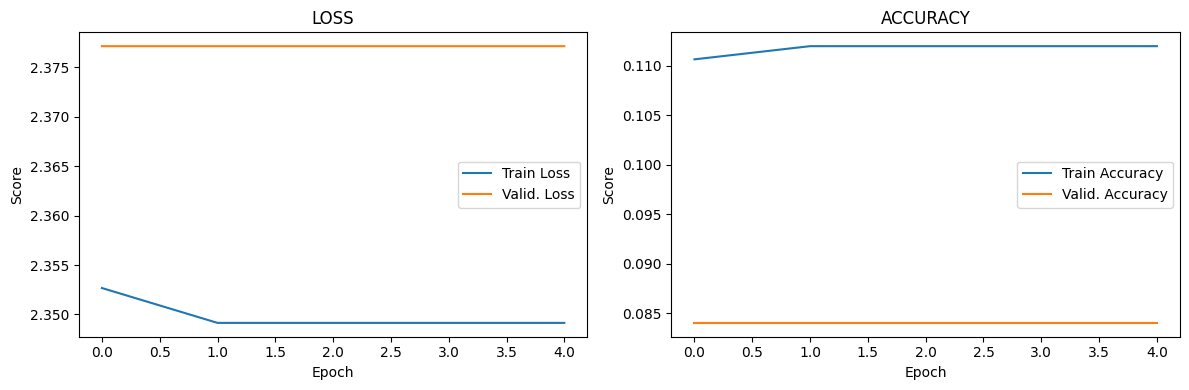

In [ ]:
plot_performance(results)

### NEXT ROUND: Retrain the model with frozen layers

In [ ]:
FROZEN_RESULTS = []
for idx, m in enumerate([model_freeze_block1, model_freeze_block12]):
    print("id: {}".format(idx))
    trainable_model_params = [p for p in m.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    new_results = fit(model=m, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)
    FROZEN_RESULTS.append(new_results)

id: 0


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.355, Validation loss: 2.369, Validation accuracy: 9.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.354, Validation loss: 2.369, Validation accuracy: 9.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.354, Validation loss: 2.369, Validation accuracy: 9.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 2.354, Validation loss: 2.369, Validation accuracy: 9.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 2.354, Validation loss: 2.369, Validation accuracy: 9.200
Training time: 43.701s
id: 1


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.354, Validation loss: 2.349, Validation accuracy: 11.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.358, Validation loss: 2.349, Validation accuracy: 11.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.358, Validation loss: 2.349, Validation accuracy: 11.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 2.358, Validation loss: 2.349, Validation accuracy: 11.200


Loss:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 2.358, Validation loss: 2.349, Validation accuracy: 11.200
Training time: 43.884s


### Examine the difference in both accuracy and loss

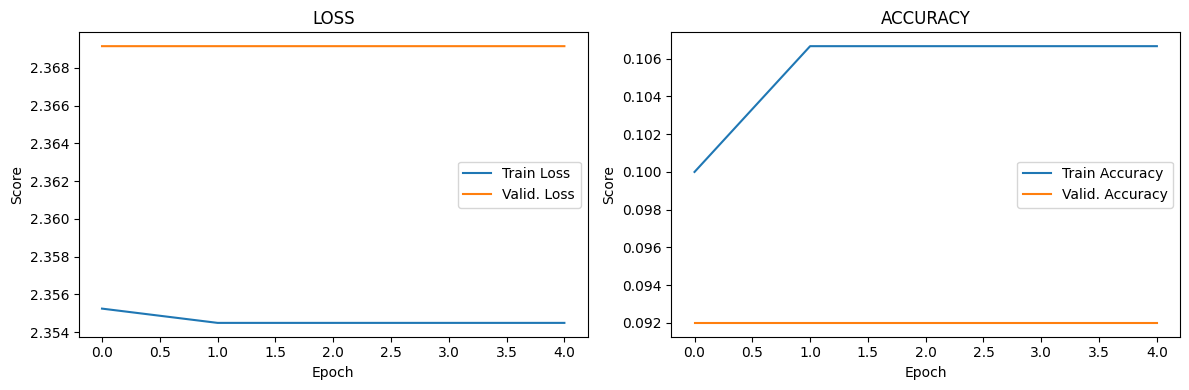

In [ ]:
plot_performance(FROZEN_RESULTS[0])

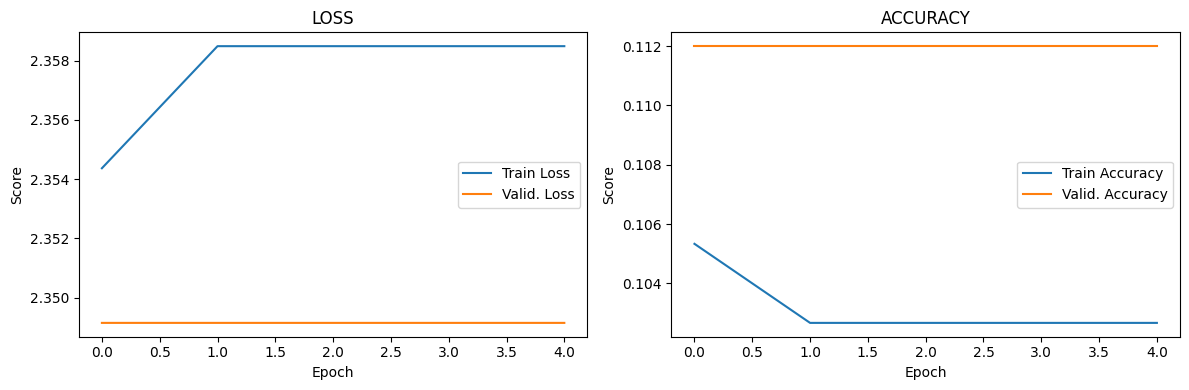

In [ ]:
plot_performance(FROZEN_RESULTS[1])

In [ ]:
# [ PERTANYAAN ]
# TODO: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?

[ ANSWER HERE ]
<BR>Dengan 5 iterasi yang sama, transfer learning dengan layer yang difreeze memiliki akurasi yang lebih buruk di akhir karena model kehilangan beberapa pengetahuan/data sebelumnya dari layer yang di freeze. Untuk mendapatkan akurasi yang lebih baik, model perlu melakukan iterasi yang lebih banyak agar model bisa lebih fleksibel dan menyesuaikan dengan data baru.

In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?

[ ANSWER HERE ]
<br>Semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi. Hal itu terjadi karena dengan freezing model kehilangan beberapa  data-data (weight) sebelumnya. Sehingga pada iterasi awal, akurasinya lebih rendah.

### Examine the difference in the execution time

In [ ]:
print("When all layers were TRAINABLE: {:.3f}s.".format(results["exc_time"]))
print("Only 'denseblock1' was FROZEN: {:.3f}s.".format(FROZEN_RESULTS[0]["exc_time"]))
print("Only 'denseblock1' and 'denseblock2' wwere FROZEN: {:.3f}s.".format(FROZEN_RESULTS[1]["exc_time"]))

When all layers were TRAINABLE: 46.187s.
Only 'denseblock1' was FROZEN: 43.701s.
Only 'denseblock1' and 'denseblock2' wwere FROZEN: 43.884s.


In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

[ ANSWER HERE ]
<br>Hal tersebut terjadi karena pada layer yang dibekukan tidak diakukan backpropagation (pembaruan nilai gradien) sehingga komputasi menjadi lebih cepat.

### Scoring
Total `#TODO` = 12
<br>Checklist:

- [✓] Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
- [✓] Ubah output layer DenseNet dengan 10 kelas
- [✓] Ubah susunan input layer ViT dengan memanggil create_conv2d()
- [✓] Ubah output layer ViT dengan 10 kelas
- [✓] Tentukan nilai batch size
- [✓] Tentukan nilai learning rate
- [✓] Tentukan loss function (untuk multi-classification)
- [✓] Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
- [✓] Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
- [✓] PERTANYAAN: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?
- [✓] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?
- [✓] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

### Additional readings
* ResNet: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* DenseNet: https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
* Vision Transformer (ViT): https://arxiv.org/pdf/2010.11929.pdf
* MNIST Classification w/ PyTorch (Beginner): https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc

### Copyright © 2024 Startup Campus, Indonesia
* Prepared by **Nicholas Dominic, M.Kom.** [(profile)](https://linkedin.com/in/nicholas-dominic)
* You may **NOT** use this file except there is written permission from PT. Kampus Merdeka Belajar (Startup Campus).
* Please address your questions to mentors.